In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras import models

from numpy import argmax

In [2]:
%%capture
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IDPzkXd8OVEPAZmujhgR1rXs_dXHOFJj' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1IDPzkXd8OVEPAZmujhgR1rXs_dXHOFJj" -O data.csv && rm -rf /tmp/cookies.txt

In [3]:
df = pd.read_csv('data.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.88791,0.096987,0.011308,0.003415,0.000304,0.000000,0.000076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.05,0,0,30.0
1,0.88966,0.095242,0.011535,0.003263,0.000228,0.000076,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.05,0,0,30.0
2,0.88617,0.098581,0.010852,0.004098,0.000228,0.000076,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.05,0,0,30.0
3,0.89413,0.093193,0.009259,0.003187,0.000076,0.000076,0.000076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.97,0,0,30.0
4,0.89171,0.093420,0.010245,0.004174,0.000152,0.000228,0.000076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.97,0,0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,0.99211,0.007741,0.000152,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.13,270,9,50.0
2405,0.98945,0.010473,0.000076,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.13,270,9,50.0
2406,0.99105,0.008803,0.000076,0.000076,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.13,270,9,50.0
2407,0.98975,0.010169,0.000076,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.13,270,9,50.0


In [4]:
#Separación por escenarios

df_B2B=df.iloc[0:987,:] #Back to back

df_fiber_0=df.iloc[988:1520,:] #Con fibra a 0dBm

df_fiber_9=df.iloc[1521:,:] #Con fibra a 9dBm

#df_fiber=df.iloc[988:,:] #Con fibra

In [5]:
data=df_B2B
variables=17

#Separando variables
X=data.iloc[:,0:variables].values #Variables

y=data.iloc[:,19:20].values #etiquetas

list_X=list(range(variables))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=26)
print('X_train length: ',X_train.shape)
print('y_train length: ',y_train.shape)
print('X_test length: ',X_test.shape)
print('y_test length: ',y_test.shape)

#Estandarización de las variables de entrada
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train length:  (690, 17)
y_train length:  (690, 1)
X_test length:  (297, 17)
y_test length:  (297, 1)


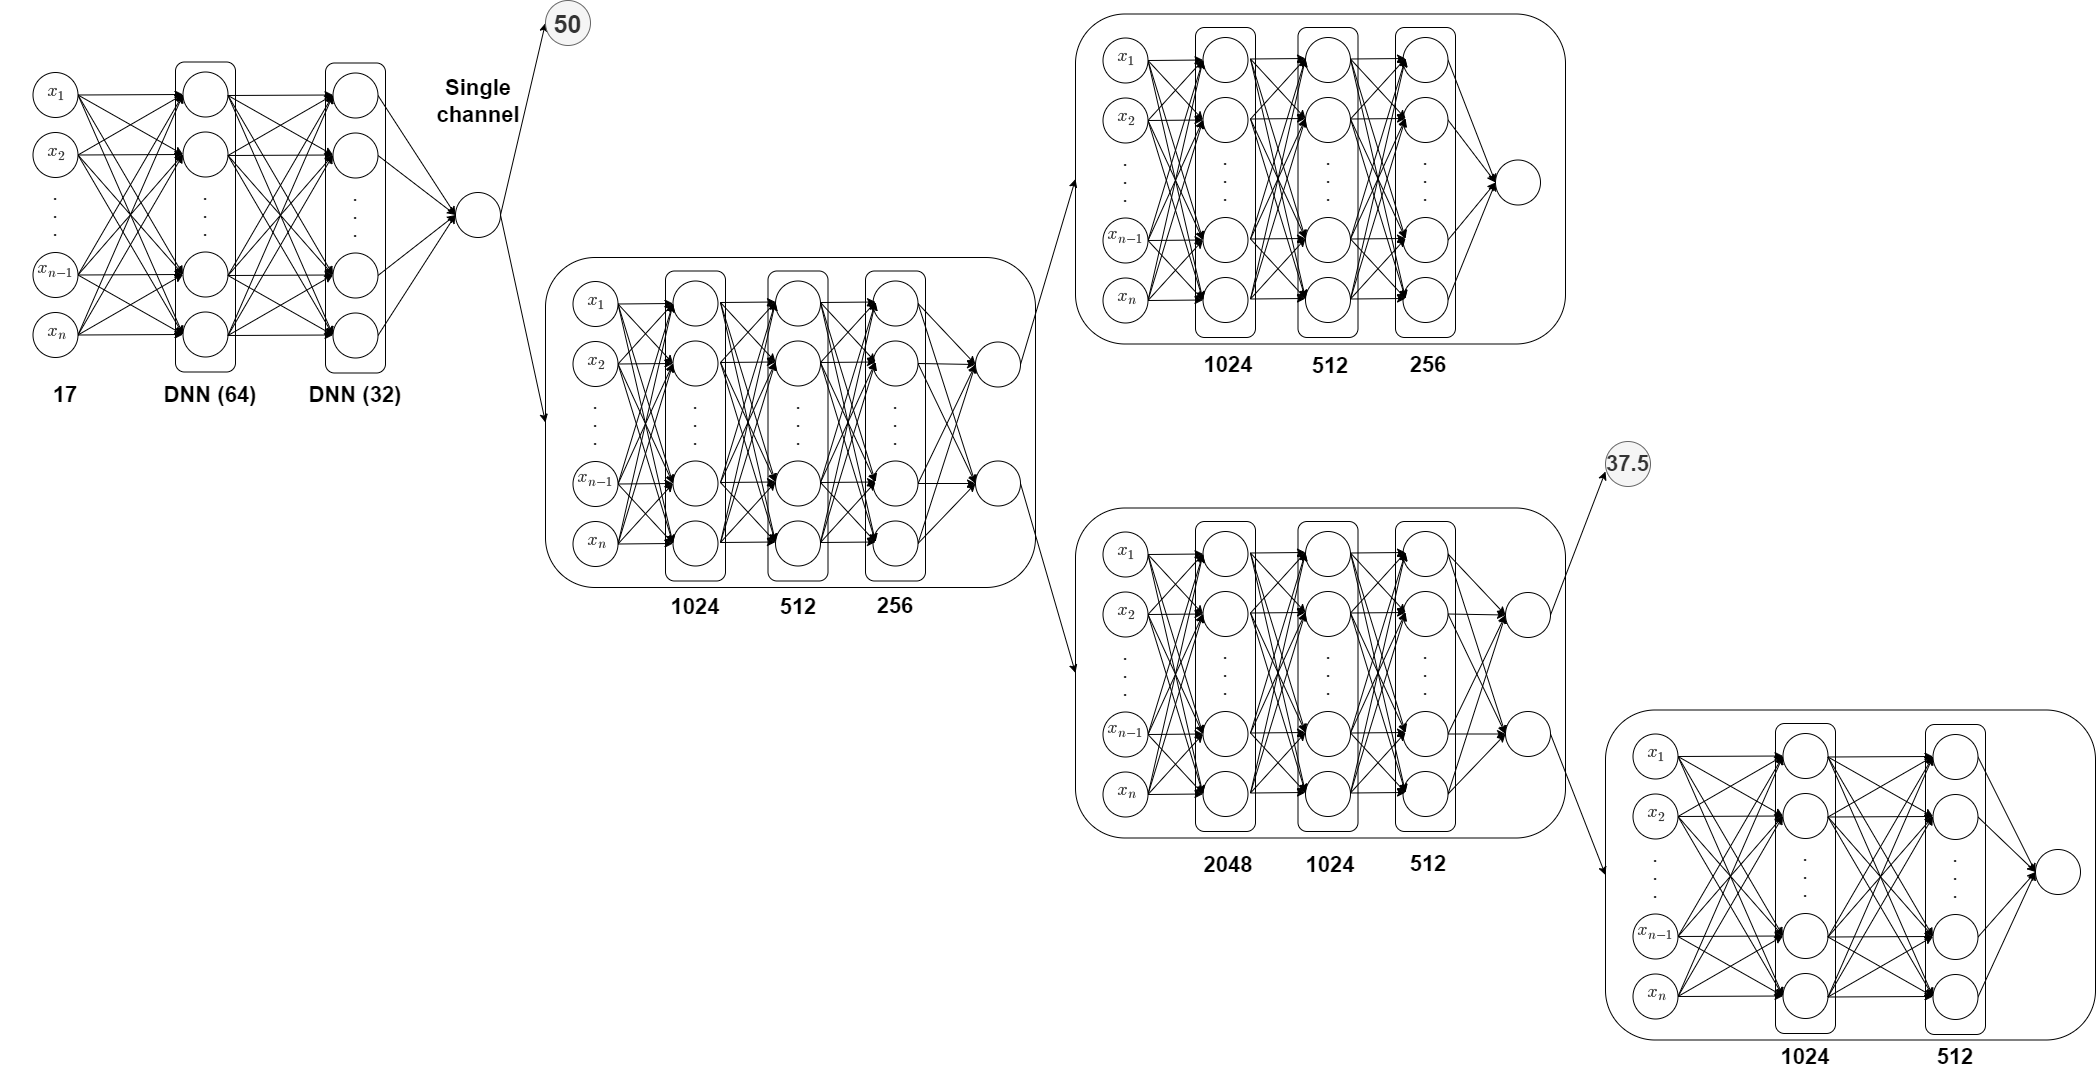

In [6]:
# Etapa 1
# Separando los datos con interferencia igual a 50 GHz de las demás
y_copy = y_train.copy()
for fil in range (len(y_copy)):
    if(y_copy[fil]<=40):
        # Se asigna 1 a los valores que no son 50 para aumentar 
        # la cantidad de umbrales posibles que se podrían definir

        # Se asigna 1 a los valores menores o iguales a 40, para
        # aumentar la cantidad de umbrales posibles que se podrían
        # definir *
        y_copy[fil]=1 

# Primera red neuronal
callback = EarlyStopping(monitor='loss', patience=20, mode='min',restore_best_weights=True)
model = Sequential()
# ¿Cambiar swish por Swish?
# Pocas neuronas a comparación de los otros modelos
model.add(Dense(units=64, input_dim=len(list_X), activation='swish'))
model.add(Dense(units=32, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')
history_1 = model.fit(X_train, y_copy, epochs=2000, batch_size=32, callbacks=[callback],
                      verbose=0)
print(len(history_1.history['loss']))
Train_predictions_1=model.predict(X_train)
TrainData_1=pd.DataFrame(data=y_copy, columns=['ICI'])
TrainData_1['PreICI']=Train_predictions_1
TrainData_1['aprox']=TrainData_1['PreICI']

# Cálculo del MAE
Train_error_absoluto_medio_1=mean_absolute_error(TrainData_1['ICI'],TrainData_1['PreICI'])

# Cálculo del R²
Train_error_R2_1=r2_score(TrainData_1['ICI'],TrainData_1['PreICI'])

#Guardar pesos primera capa
model.save('model_capa_1.h5')

# Se reduce la regresión a una clasificación (?)
for fil in range(TrainData_1.shape[0]):
    if(TrainData_1['PreICI'][fil]<=3):
        TrainData_1['aprox'][fil]=1
    else:
        TrainData_1['aprox'][fil]=50

# Se calculan los errores
error_train_1=0
for fil in range (TrainData_1.shape[0]):
    if(TrainData_1['aprox'][fil]!=TrainData_1['ICI'][fil]):
        error_train_1 += 1

print(f'El error de esta etapa es: {error_train_1/len(y_copy):.6f}')
        
TrainData_1['Original'] = y_train
print(TrainData_1)

1355
El error de esta etapa es: 0.026087
      ICI     PreICI  aprox  Original
0     1.0   0.987962    1.0      37.5
1     1.0   1.000819    1.0      32.5
2     1.0   0.986839    1.0      33.5
3     1.0   0.994600    1.0      36.0
4     1.0   0.918976    1.0      33.5
..    ...        ...    ...       ...
685  50.0  50.016319   50.0      50.0
686   1.0   0.999364    1.0      34.0
687   1.0   0.992602    1.0      36.0
688   1.0   0.990640    1.0      33.0
689   1.0   0.641296    1.0      37.5

[690 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# ETAPA 2 CLASIFICADOR
pos_50=[x[0] for x in np.argwhere(np.asarray(TrainData_1['aprox'])==50.0)]
pos_other=[x[0] for x in np.argwhere(np.asarray(TrainData_1['aprox'])!=50.0)]

X_50=X_train[pos_50]
y_50=y_train[pos_50]
X_other=X_train[pos_other]
y_other=y_train[pos_other]
                      
y_copy_2 = y_other.copy()
for fil in range (len(y_copy_2)):
    if(y_copy_2[fil]<=35.2):
        y_copy_2[fil]=0
    else:
        y_copy_2[fil]=1

callback = EarlyStopping(monitor='loss', patience=300, mode='min',restore_best_weights=True)
model = Sequential()
# ¿Cambiar swish por Swish?
model.add(Dense(units=1024, input_dim=len(list_X), activation='swish'))
model.add(Dense(units=512, activation='tanh'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
history_2 = model.fit(X_other, y_copy_2, epochs=5000, batch_size=32, callbacks=[callback],
                      verbose=0)
print(len(history_2.history['loss']))
Train_predictions_2_1=model.predict(X_other)
Train_predictions_2_1 = argmax(Train_predictions_2_1, axis=-1).astype('int')
acc = accuracy_score(y_copy_2, Train_predictions_2_1)

print(f'El error de esta etapa es: {1 - acc:.6f}')

#Guardar pesos segunda capa
model.save('model_capa_2.h5')

TrainData_2_1=pd.DataFrame(data=y_copy_2, columns=['ORIGINAL'])
TrainData_2_1['PreICI']=Train_predictions_2_1

print(TrainData_2_1)

TrainData_2_1['ERROR']= np.abs(TrainData_2_1['PreICI']-TrainData_2_1['ORIGINAL'])

error_absoluto_medio_1=mean_absolute_error(TrainData_2_1['ORIGINAL'],TrainData_2_1['PreICI'])
r2_1=r2_score(TrainData_2_1['ORIGINAL'],TrainData_2_1['PreICI'])

print(f'The Mean Absolute Error of ANN model is: {error_absoluto_medio_1:.6f}')
print(f'The R² score of ANN model is: {r2_1:.6f}')

3179
El error de esta etapa es: 0.073090
     ORIGINAL  PreICI
0         1.0       1
1         0.0       0
2         0.0       0
3         1.0       1
4         0.0       0
..        ...     ...
597       0.0       0
598       0.0       0
599       1.0       1
600       0.0       0
601       1.0       1

[602 rows x 2 columns]
The Mean Absolute Error of ANN model is: 0.073090
The R² score of ANN model is: 0.636713


In [8]:
#%% TERCERA ETAPA
pos_with=[x[0] for x in np.argwhere(Train_predictions_2_1==0)]
pos_without=[x[0] for x in np.argwhere(Train_predictions_2_1==1)]
X_with=X_other[pos_with]
y_with=y_other[pos_with]
X_without=X_other[pos_without]
y_without=y_other[pos_without]

pos_without_2=[]
pos_without_3=[]
pos_without_50=[]

pos_with_2=[]
for i in pos_without:
    if y_other[i]<36.5 and y_other[i]>=35.5:
        pos_without_2.append(i)
    elif (y_other[i]>36.5 and y_other[i]<40):
        pos_without_3.append(i)
    else:
        pos_without_50.append(i)

for i in pos_with:
    if y_other[i]<35.2:
        pos_with_2.append(i)

X_without_2=X_other[pos_without_2]
y_without_2=y_other[pos_without_2]
X_without_3=X_other[pos_without_3]
y_without_3=y_other[pos_without_3]
X_with_2=X_other[pos_with_2]
y_with_2=y_other[pos_with_2]

#ETAPA 3 - 1 -> 30 - 35 GHz
callback = EarlyStopping(monitor='loss', patience=300, mode='min',restore_best_weights=True)
model = Sequential()
model.add(Dense(units=1024, input_dim=len(list_X),  activation='swish'))
model.add(Dense(units=512, activation='tanh'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='Adam')
history_2 = model.fit (X_with_2, y_with_2, epochs=5000, batch_size=32, callbacks=[callback],
                    verbose=0)
print(len(history_2.history['loss']))
Train_predictions_2_1=model.predict(X_with_2)

TrainData_2_1=pd.DataFrame(data=y_with_2, columns=['ORGINAL'])

TrainData_2_1['PreICI']=Train_predictions_2_1

#print(TrainData_2_1)

#Guardar pesos tercera capa
model.save('model_capa_3_1.h5')

TrainData_2_1['ERROR']= np.abs(TrainData_2_1['PreICI']-TrainData_2_1['ORGINAL'])

error_absoluto_medio_2=mean_absolute_error(TrainData_2_1['ORGINAL'],TrainData_2_1['PreICI'])
r2_2=r2_score(TrainData_2_1['ORGINAL'],TrainData_2_1['PreICI'])

print(f'The Mean Absolute Error of ANN model is: {error_absoluto_medio_2:.6f}')
print(f'The R² score of ANN model is: {r2_2:.6f}')

3267
The Mean Absolute Error of ANN model is: 0.124737
The R² score of ANN model is: 0.942319


In [9]:
#%% ETAPA 3-2 35.5,36 - 37.5 GHz
y_copy_2=y_without.copy()
for fil in range (len(y_copy_2)):
    if(y_without[fil]>=35.2 and y_without[fil]<=36):
        y_copy_2[fil]=0
    else:
        y_copy_2[fil]=1

callback = EarlyStopping(monitor='loss', patience=300, mode='min',restore_best_weights=True)
model = Sequential()
model.add(Dense(units=1024*2, input_dim=len(list_X),  activation='swish'))
model.add(Dense(units=512*2, activation='tanh'))
model.add(Dense(units=256*2, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
history = model.fit (X_without, y_copy_2, epochs=5000, batch_size=32, callbacks=[callback],
                    verbose=0)
print(len(history.history['loss']))
Train_predictions_3=model.predict(X_without)
Train_predictions_3 = argmax(Train_predictions_3, axis=-1).astype('int')
acc_3t = accuracy_score(y_copy_2, Train_predictions_3)
model.save('model_capa_3.h5')
print(f'El error de esta etapa es {1 - acc_3t}')

3686
El error de esta etapa es 0.15104166666666663


In [10]:
pos_with_3=[x[0] for x in np.argwhere(Train_predictions_3==0)]
pos_without_3=[x[0] for x in np.argwhere(Train_predictions_3==1)]

X_without_3_1=X_without[pos_with_3]
y_without_3_1=y_without[pos_with_3]

X_without_3_2=X_without[pos_without_3]
y_without_3_2=y_without[pos_without_3]

pos_without_3_1=[]
pos_without_3_2=[]

for i in pos_without_3:
    if y_without[i][0]<36.5 and y_without[i][0]>=35.5:
        pos_without_3_1.append(i)    
    else:
        pos_without_3_2.append(i)

X_without_3=X_without[pos_without_3_1]
y_without_3=y_without[pos_without_3_1]


#%% ETAPA 4 35.5 - 36
callback = EarlyStopping(monitor='loss', patience=300, mode='min',restore_best_weights=True)
model = Sequential()
model.add(Dense(units=1024, input_dim=len(list_X),  activation='swish'))
model.add(Dense(units=512,activation='tanh'))
model.add(Dense(units=256,activation='sigmoid'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='Adam')
history = model.fit (X_without_3, y_without_3, epochs=5000, batch_size=32, callbacks=[callback],
                    verbose=0)
print(len(history.history['loss']))
Train_predictions_2_2=model.predict(X_without_3)

TrainData_2_2=pd.DataFrame(data=y_without_3, columns=['ORIGINAL'])

TrainData_2_2['PreICI']=Train_predictions_2_2

print(TrainData_2_2)

#Guardar pesos cuarta capa
model.save('model_capa_3_2.h5')

#TrainData_2_2['Aprox']=TrainData_2_2['PreICI'].apply(lambda x: custom_round(x, base=1))

#acc = accuracy_score(TrainData_2_2['Aprox'], TrainData_2_2['ORIGINAL'])
 
TrainData_2_2['ERROR']= np.abs(TrainData_2_2['PreICI']-TrainData_2_2['ORIGINAL'])

error_absoluto_medio_3t=mean_absolute_error(TrainData_2_2['ORIGINAL'],TrainData_2_2['PreICI'])
r2_3t=r2_score(TrainData_2_2['ORIGINAL'],TrainData_2_2['PreICI'])

print(f'The Mean Absolute Error of ANN model is: {error_absoluto_medio_3t:.6f}')
print(f'The R² score of ANN model is: {r2_3t:.6f}')

660
    ORIGINAL     PreICI
0       35.5  35.495205
1       35.5  35.495216
2       36.0  35.495724
3       35.5  35.495792
4       35.5  35.495792
5       36.0  35.495728
6       36.0  35.495792
7       35.5  35.495735
8       35.5  35.495735
9       35.5  35.495647
10      35.5  35.495792
11      36.0  35.495785
12      35.5  35.495728
13      35.5  35.495731
14      36.0  35.495728
15      35.5  35.495640
16      36.0  35.495724
The Mean Absolute Error of ANN model is: 0.180794
The R² score of ANN model is: -0.572076


In [11]:
#%% Test
#Primera etapa
new_model = models.load_model('model_capa_1.h5')

prediction_1 = new_model.predict(X_test)

TestData_2_2=pd.DataFrame(data=y_test, columns=['ORIGINAL'])

TestData_2_2['PreICI_1']=prediction_1

for fil in range (TestData_2_2.shape[0]):
    if(TestData_2_2['PreICI_1'][fil]<=3):
        TestData_2_2['PreICI_1'][fil]=1
    else:
        TestData_2_2['PreICI_1'][fil]=50


y_copy = y_test.copy()
for fil in range (len(y_copy)):
    if(y_copy[fil]<=40):
        y_copy[fil]=1
        
acc_1 = accuracy_score(y_copy, TestData_2_2['PreICI_1'])
print('El error de la primera etapa es: ',(1-acc_1)*100,' %')
#Segunda Etapa
aciertos_50=0
falsos_50=0
for fil in range (TestData_2_2.shape[0]):
    if(TestData_2_2['PreICI_1'][fil]==TestData_2_2['ORIGINAL'][fil]):
        aciertos_50+=1
    if (TestData_2_2['PreICI_1'][fil]!=TestData_2_2['ORIGINAL'][fil] and TestData_2_2['PreICI_1'][fil]==50):
        falsos_50+=1

pos_50_test=[x[0] for x in np.argwhere(np.asarray(TestData_2_2['PreICI_1'])==50.0)]
pos_other_test=[x[0] for x in np.argwhere(np.asarray(TestData_2_2['PreICI_1'])!=50.0)]

test_pred=[0]*len(y_test)

for i in pos_50_test:
    test_pred[i]=TestData_2_2['PreICI_1'][i]
    
X_other_test=X_test[pos_other_test]
y_other_test=y_test[pos_other_test]
                   
new_model_2 = models.load_model('model_capa_2.h5')

prediction_2 = new_model_2.predict(X_other_test)

prediction_2 = argmax(prediction_2, axis=-1).astype('int')

y_copy = y_test[pos_other_test].copy()
for fil in range (len(y_copy)):
    if(y_copy[fil]<=35.2):
        y_copy[fil]=0
    else:
        y_copy[fil]=1
test_pred.append(prediction_2)
#test_test.append(y_test[pos_other_test])
        
acc_2 = accuracy_score(y_copy, prediction_2)  
print('El error de la segunda etapa con los datos de prueba es: ',(1-acc_2)*100, ' %')

#Tercera Etapa
pos_with_test=[x[0] for x in np.argwhere(prediction_2==0)]
pos_without_test=[x[0] for x in np.argwhere(prediction_2==1)]

list_0=[pos_other_test[i] for i in pos_with_test]
list_1=[pos_other_test[i] for i in pos_without_test]
        
X_with_test=X_other_test[pos_with_test]
X_without_test=X_other_test[pos_without_test]
y_without_test=y_other_test[pos_without_test]

#Datos con interferencia
new_model_3_1 = models.load_model('model_capa_3_1.h5')
prediction_3_1 = new_model_3_1.predict(X_with_test)

error_absoluto_medio_3=mean_absolute_error(y_other_test[pos_with_test],prediction_3_1)
r2_3=r2_score(y_other_test[pos_with_test],prediction_3_1)

print(f'El error absoluto medio de la tercera etapa con los datos de prueba con interferencia es: {error_absoluto_medio_3:.6f}')
print(f'El puntaje R² de la tercera etapa con los datos de prueba con interferencia es: {r2_3:.6f}')

j=0
for i in list_0:
    test_pred[i]=prediction_3_1[j]
    j+=1
#Datos sin interfencia    
new_model_3=models.load_model('model_capa_3.h5')
prediction_3 = new_model_3.predict(X_without_test)
prediction_3 = argmax(prediction_3, axis=-1).astype('int')

y_copy = y_other_test[pos_without_test].copy()

for fil in range (len(y_copy)):
    if(y_copy[fil]<=36):
        y_copy[fil]=0
    else:
        y_copy[fil]=1
        
acc_3 = accuracy_score(y_copy, prediction_3)
print('El error de la tercera etapa con los datos de prueba sin interferencia separando entre 37.5 y los restantes es: ',acc_3)

#Etapa cuatro
pos_without_4=[x[0] for x in np.argwhere(prediction_3==0)]
pos_without_5=[x[0] for x in np.argwhere(prediction_3==1)]

list_4=[list_1[i] for i in pos_without_4]
list_5=[list_1[i] for i in pos_without_5]

j=0
for i in list_5:
    test_pred[i]=37.5
    j+=1
    
X_with_test_4=X_without_test[pos_without_4]
#X_without_test_4=X_other_test[pos_without_4]

new_model_3_2 = models.load_model('model_capa_3_2.h5')
prediction_3_2 = new_model_3_2.predict(X_with_test_4)

j=0
for i in list_4:
    test_pred[i]=prediction_3_2[j]
    j+=1
    
error_absoluto_medio_4=mean_absolute_error(y_without_test[pos_without_4],prediction_3_2)
r2_4=r2_score(y_without_test[pos_without_4],prediction_3_2)
print(f'El error absoluto medio de la cuarta etapa es: {error_absoluto_medio_4:.6f}')
print(f'El puntaje R² de la cuarta etapa es: {r2_4:.6f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


El error de la primera etapa es:  5.05050505050505  %
El error de la segunda etapa con los datos de prueba es:  18.726591760299627  %
El error absoluto medio de la tercera etapa con los datos de prueba con interferencia es: 0.538461
El puntaje R² de la tercera etapa con los datos de prueba con interferencia es: 0.720537
El error de la tercera etapa con los datos de prueba sin interferencia separando entre 37.5 y los restantes es:  0.6538461538461539
El error absoluto medio de la cuarta etapa es: 9.607754
El puntaje R² de la cuarta etapa es: -220.916447


In [12]:
test_pred = test_pred[:-1]
error_absoluto_medio_test=mean_absolute_error(y_test,test_pred)
r2_test=r2_score(y_test,test_pred)
print(f'El error absoluto medio del modelo es: {error_absoluto_medio_test}')
print(f'El puntaje R² del modelo es: {r2_test}')

El error absoluto medio del modelo es: 2.8699404567179054
El puntaje R² del modelo es: -3.406049482298738


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or